# Predict the City Taxi Trip Duration

Import all necessary packages here

In [1]:
import pandas as pd
import datetime
import numpy as np
from math import radians
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

## Import the data

In [2]:
df=pd.read_csv(r'train.csv')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


## Study the data

In [3]:
df.shape

(1458644, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [5]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


# Process The Data

Add the Year, Month , Hours, Minutes and Days as the features to the dataframe

In [6]:
pd.to_datetime(df['pickup_datetime'])

0         2016-03-14 17:24:55
1         2016-06-12 00:43:35
2         2016-01-19 11:35:24
3         2016-04-06 19:32:31
4         2016-03-26 13:30:55
                  ...        
1458639   2016-04-08 13:31:04
1458640   2016-01-10 07:35:15
1458641   2016-04-22 06:57:41
1458642   2016-01-05 15:56:26
1458643   2016-04-05 14:44:25
Name: pickup_datetime, Length: 1458644, dtype: datetime64[ns]

In [7]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [8]:
df['Year']=df['pickup_datetime'].dt.year
df['Month']=df['pickup_datetime'].dt.month
df['Day']=df['pickup_datetime'].dt.day
df['Hours']=df['pickup_datetime'].dt.hour
df['Minutes']=df['pickup_datetime'].dt.minute

Add a feature to the dataframe which checks if it is day time or night time

In [9]:
df['mornight']=np.where(df['Hours']<12,0,1)

In [10]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Year,Month,Day,Hours,Minutes,mornight
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,3,14,17,24,1
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,6,12,0,43,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016,1,19,11,35,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016,4,6,19,32,1
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016,3,26,13,30,1


Calculate the Distance travelled with the help of latitudes and longtitudes of the pickup and dropoff locations

the distance is in meters

In [11]:
def haversine(df):
    lat1 = np.radians(df["pickup_latitude"])
    lat2 = np.radians(df["dropoff_latitude"])
    dlat = np.radians(df['dropoff_latitude']-df["pickup_latitude"])
    dlong = np.radians(df["dropoff_longitude"]-df["pickup_longitude"])
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlong/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r * 1000

In [12]:
df['total_distance'] = haversine(df)

In [13]:
df.drop(["id","pickup_datetime","dropoff_datetime","store_and_fwd_flag","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"],axis=1,inplace=True)
df.head()

,vendor_id,passenger_count,trip_duration,Year,Month,Day,Hours,Minutes,mornight,total_distance
0,2,1,455,2016,3,14,17,24,1,1498.520780
1,1,1,663,2016,6,12,0,43,0,1805.507169
2,2,1,2124,2016,1,19,11,35,0,6385.098495
3,2,1,429,2016,4,6,19,32,1,1485.498423
4,2,1,435,2016,3,26,13,30,1,1188.588459


### check for outliers

In [14]:
df.describe()

,vendor_id,passenger_count,trip_duration,Year,Month,Day,Hours,Minutes,mornight,total_distance
count,1.458644e+06,1.458644e+06,1.458644e+06,1458644.0,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,9.594923e+02,2016.0,3.516818e+00,1.550402e+01,1.360648e+01,2.959016e+01,6.373639e-01,3.440864e+03
std,4.987772e-01,1.314242e+00,5.237432e+03,0.0,1.681038e+00,8.703135e+00,6.399693e+00,1.732471e+01,4.807612e-01,4.296538e+03
min,1.000000e+00,0.000000e+00,1.000000e+00,2016.0,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,3.970000e+02,2016.0,2.000000e+00,8.000000e+00,9.000000e+00,1.500000e+01,0.000000e+00,1.231837e+03
50%,2.000000e+00,1.000000e+00,6.620000e+02,2016.0,4.000000e+00,1.500000e+01,1.400000e+01,3.000000e+01,1.000000e+00,2.093717e+03
75%,2.000000e+00,2.000000e+00,1.075000e+03,2016.0,5.000000e+00,2.300000e+01,1.900000e+01,4.500000e+01,1.000000e+00,3.875337e+03
max,2.000000e+00,9.000000e+00,3.526282e+06,2016.0,6.000000e+00,3.100000e+01,2.300000e+01,5.900000e+01,1.000000e+00,1.240909e+06


### perform z-score normalization for trip_duration

In [15]:
mean = df['trip_duration'].mean()
std = df['trip_duration'].std()
threshold = 3

z_scores = np.abs((df['trip_duration'] - mean) / std)

df = df[z_scores <= threshold]
df.describe()

,vendor_id,passenger_count,trip_duration,Year,Month,Day,Hours,Minutes,mornight,total_distance
count,1.456571e+06,1.456571e+06,1.456571e+06,1456571.0,1.456571e+06,1.456571e+06,1.456571e+06,1.456571e+06,1.456571e+06,1.456571e+06
mean,1.534295e+00,1.663944e+00,8.371182e+02,2016.0,3.516766e+00,1.550398e+01,1.360657e+01,2.959133e+01,6.373229e-01,3.439545e+03
std,4.988227e-01,1.313618e+00,6.613656e+02,0.0,1.681032e+00,8.702953e+00,6.399354e+00,1.732490e+01,4.807729e-01,4.291606e+03
min,1.000000e+00,0.000000e+00,1.000000e+00,2016.0,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,3.970000e+02,2016.0,2.000000e+00,8.000000e+00,9.000000e+00,1.500000e+01,0.000000e+00,1.231726e+03
50%,2.000000e+00,1.000000e+00,6.620000e+02,2016.0,4.000000e+00,1.500000e+01,1.400000e+01,3.000000e+01,1.000000e+00,2.093304e+03
75%,2.000000e+00,2.000000e+00,1.073000e+03,2016.0,5.000000e+00,2.300000e+01,1.900000e+01,4.500000e+01,1.000000e+00,3.874469e+03
max,2.000000e+00,9.000000e+00,1.590000e+04,2016.0,6.000000e+00,3.100000e+01,2.300000e+01,5.900000e+01,1.000000e+00,1.240909e+06


## Checking for Correlation

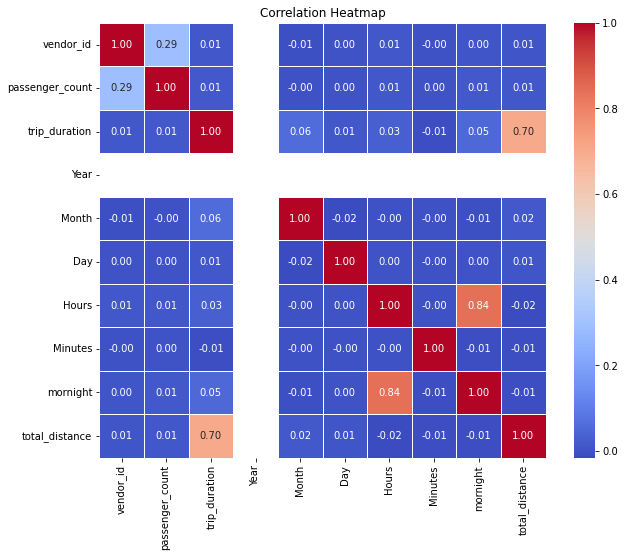

In [16]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### clean data by removing highly correlated data 

In [17]:
# Set the correlation threshold
threshold = 0.75

# Find highly correlated features
high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) >= threshold:
            colname = corr_matrix.columns[i]
            high_corr_features.add(colname)

# Remove highly correlated features from the dataframe
df = df.drop(high_corr_features, axis=1)

### drop duplicated values

In [18]:
df.drop_duplicates(inplace=True)

# Training and Testing of model

In [19]:
x = df.drop('trip_duration', axis=1)
y = df['trip_duration']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### Linear Regression Model

In [20]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model_train_score=model.score(X_train,y_train)
model_test_score=model.score(X_test,y_test)
print("Model Training Score:",model_train_score)
print("Model Regression Test Score:",model_test_score)

Model Training Score: 0.4759421840362712
Model Regression Test Score: 0.5494575398629931


### Ridge Model

In [21]:
model = Ridge(alpha=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model_train_score=model.score(X_train,y_train)
model_test_score=model.score(X_test,y_test)
print("Model Training Score:",model_train_score)
print("Model Regression Test Score:",model_test_score)

Model Training Score: 0.47594218403312805
Model Regression Test Score: 0.5494575400218615


### Lasso Model

In [22]:
model = Lasso(alpha=0.001,max_iter=10^5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model_train_score=model.score(X_train,y_train)
model_test_score=model.score(X_test,y_test)
print("Model Training Score:",model_train_score)
print("Model Regression Test Score:",model_test_score)

Model Training Score: 0.47594218402598854
Model Regression Test Score: 0.5494575371782109


### LightGBM Model

In [23]:
train_data = lgb.Dataset(X_train, label=y_train)

# Set the hyperparameters for the LightGBM model
params = {
    'objective': ['regression'],
    'metric': ['r2'],
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'verbose': [0],
    'force_row_wise': [True]
}

train_data = lgb.Dataset(X_train, label=y_train)

model = lgb.LGBMRegressor()

grid_search = GridSearchCV(model, params, scoring='r2', cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

model_test_score = best_model.score(X_test, y_test)

print("Best Model Test Score:", model_test_score)

Best Model Test Score: 0.719501232696709


### So this is the model with a 71.95% accuracy

Model created trained and tested by Aritro Saha